In [10]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Replace with your actual Finnhub API key
api_key = 'cv0ael9r01qo8ssfl1s0cv0ael9r01qo8ssfl1sg'
base_url = 'https://finnhub.io/api/v1/news?category=general&token='

# Expand Stock Keywords Mapping
stock_keywords = {
    'AAPL': ['Apple', 'iPhone', 'MacBook', 'Tim Cook', 'Apple Inc.'],
    'TSLA': ['Tesla', 'Elon Musk', 'Model 3', 'SpaceX', 'Cybertruck'],
    'AMZN': ['Amazon', 'AWS', 'Jeff Bezos', 'Amazon Prime'],
    'GOOGL': ['Google', 'Alphabet', 'Sundar Pichai', 'Gmail', 'Google Cloud'],
    'MSFT': ['Microsoft', 'Azure', 'Windows', 'Satya Nadella', 'Office 365'],
    'NVDA': ['Nvidia', 'GPU', 'RTX', 'AI', 'Jensen Huang'],
    'META': ['Meta', 'Facebook', 'Mark Zuckerberg', 'WhatsApp', 'Instagram'],
}

# Function to match news articles with stock tickers based on keywords
def match_stock(news_text):
    for ticker, keywords in stock_keywords.items():
        if any(keyword in news_text for keyword in keywords):
            return ticker
    return "Unknown"

# Function to Fetch News Data
def fetch_news_data():
    all_news = []
    
    for i in range(60):  # Collect news from last 60 days
        date = (datetime.now() - timedelta(days=i)).strftime('%Y-%m-%d')
        
        response = requests.get(f'{base_url}{api_key}')
        
        # Handle API response issues
        if response.status_code != 200:
            print(f"⚠ Error fetching news for {date} - HTTP {response.status_code}")
            print(f"🔍 API Response: {response.text}")  # Print error details
            continue
        
        news_items = response.json()
        
        # Ensure data is not empty
        if not news_items:
            print(f"⚠ No news articles found for {date}")
            continue
        
        # Process each news item
        for item in news_items:
            headline = item.get('headline', '')
            summary = item.get('summary', '')
            sentiment_score = analyzer.polarity_scores(headline + " " + summary)['compound']
            
            # Match stock ticker based on keywords
            stock_name = match_stock(headline + " " + summary)
            
            news_entry = {
                'Date': date,
                'Stock Name': stock_name,
                'Headline': headline,
                'Summary': summary,
                'Sentiment Score': sentiment_score
            }
            all_news.append(news_entry)
    
    return pd.DataFrame(all_news) if all_news else pd.DataFrame()

# Fetch news data and perform sentiment analysis
sentiment_df = fetch_news_data()

# Remove 'Unknown' tickers to keep only valid matches
sentiment_df = sentiment_df[sentiment_df['Stock Name'] != "Unknown"]

# Save the dataset
if not sentiment_df.empty:
    sentiment_df.to_csv("stock_sentiment_analysis.csv", index=False)
    print(f"✅ Sentiment dataset saved with {len(sentiment_df)} valid entries.")
else:
    print("❌ No valid sentiment data available. Please check API response.")

# Display sample of dataset
print(sentiment_df.head())


✅ Sentiment dataset saved with 960 valid entries.
          Date Stock Name                                           Headline  \
6   2025-02-27       NVDA  Salesforce’s growth hits a bad milestone. Can ...   
10  2025-02-27       NVDA  Nvidia’s stock is in a funk. Earnings didn’t h...   
12  2025-02-27       NVDA  Nvidia is biggest chip player. But it also lea...   
14  2025-02-27       MSFT  Snowflake surges 13% on earnings beat as compa...   
33  2025-02-27       NVDA  Rolls-Royce has been outperformed by Palantir,...   

                                              Summary  Sentiment Score  
6   The cloud software pioneer delivered an annual...           0.5267  
10  Can Nvidia’s GTC conference give the stock a b...           0.6597  
12  These 15 companies are expected to show the hi...           0.7227  
14  Snowflake announced an expanded partnership wi...           0.1027  
33  Rolls-Royce, the engine maker that’s been one ...           0.7964  


In [11]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import time

# Load Sentiment Data
sentiment_data_path = "stock_sentiment_analysis.csv"
sentiment_df = pd.read_csv(sentiment_data_path)

# Convert Date to datetime format
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])

# Define Tickers & Time Range
tickers = sentiment_df['Stock Name'].unique()
start_date = (sentiment_df['Date'].min() - timedelta(days=5)).strftime('%Y-%m-%d')  # Buffer for missing days
end_date = sentiment_df['Date'].max().strftime('%Y-%m-%d')

# Function to Fetch Stock Prices
def fetch_stock_prices(tickers, start_date, end_date):
    stock_data = []
    
    for ticker in tickers:
        try:
            stock_df = yf.download(ticker, start=start_date, end=end_date, progress=False)[['Close']]
            
            if stock_df.empty:
                print(f"⚠ No data for {ticker}. Retrying with broader range...")
                stock_df = yf.download(ticker, start=start_date - timedelta(days=5), end=end_date + timedelta(days=2), progress=False)
            
            if stock_df.empty:
                print(f"❌ Still no data for {ticker}. Skipping...")
                continue
            
            stock_df = stock_df.reset_index()
            stock_df['Stock Name'] = ticker
            stock_data.append(stock_df)
            
            time.sleep(1)  # Prevent rate limits
        
        except Exception as e:
            print(f"❌ Error fetching data for {ticker}: {e}")

    return pd.concat(stock_data, ignore_index=True) if stock_data else pd.DataFrame()

# Fetch stock prices
stock_prices_df = fetch_stock_prices(tickers, start_date, end_date)

# Ensure stock prices have data
if stock_prices_df.empty:
    raise ValueError("❌ No stock prices fetched. Check ticker symbols or API limitations.")

# Convert Date to datetime format
stock_prices_df['Date'] = pd.to_datetime(stock_prices_df['Date'])

# Merge Stock Prices with Sentiment Data
merged_df = pd.merge(sentiment_df, stock_prices_df[['Date', 'Stock Name', 'Close']], on=['Date', 'Stock Name'], how='inner')

# Save Merged Dataset
merged_df.to_csv("merged_sentiment_stock_data.csv", index=False)
print(f"✅ Merged dataset saved with {len(merged_df)} entries.")

# Display a sample of the merged dataset
print(merged_df.head())


YF.download() has changed argument auto_adjust default to True
✅ Merged dataset saved with 624 entries.
        Date Stock Name                                           Headline  \
0 2025-02-26       NVDA  Salesforce’s growth hits a bad milestone. Can ...   
1 2025-02-26       NVDA  Nvidia’s stock is in a funk. Earnings didn’t h...   
2 2025-02-26       NVDA  Nvidia is biggest chip player. But it also lea...   
3 2025-02-26       NVDA  Rolls-Royce has been outperformed by Palantir,...   
4 2025-02-26       NVDA  If you invested $1,000 in Nvidia 10 years ago,...   

                                             Summary  Sentiment Score  \
0  The cloud software pioneer delivered an annual...           0.5267   
1  Can Nvidia’s GTC conference give the stock a b...           0.6597   
2  These 15 companies are expected to show the hi...           0.7227   
3  Rolls-Royce, the engine maker that’s been one ...           0.7964   
4  If you had invested $1,000 in Nvidia when the ...          

C:\Users\srira\AppData\Local\Temp\ipykernel_24180\2035763694.py:56: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  merged_df = pd.merge(sentiment_df, stock_prices_df[['Date', 'Stock Name', 'Close']], on=['Date', 'Stock Name'], how='inner')
C:\Users\srira\AppData\Local\Temp\ipykernel_24180\2035763694.py:56: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_df = pd.merge(sentiment_df, stock_prices_df[['Date', 'Stock Name', 'Close']], on=['Date', 'Stock Name'], how='inner')


In [13]:
import pandas as pd

# Load dataset
merged_df = pd.read_csv("merged_sentiment_stock_data.csv")

# Identify columns with stock prices (they start with "('Close', ")
price_columns = [col for col in merged_df.columns if col.startswith("('Close',")]

# Melt stock price columns into a single "Stock Name" and "Close" column
melted_df = merged_df.melt(id_vars=['Date', 'Headline', 'Summary', 'Sentiment Score'], 
                            value_vars=price_columns,
                            var_name='Stock Name', 
                            value_name='Close')

# Extract correct stock name from the column
melted_df['Stock Name'] = melted_df['Stock Name'].str.extract(r"Close', '(\w+)'")

# Drop rows where Close price is NaN
melted_df = melted_df.dropna()

# Save cleaned dataset
melted_df.to_csv("final_sentiment_stock_data.csv", index=False)

print(f"✅ Cleaned dataset saved with {len(melted_df)} valid entries.")
print(melted_df.head())


✅ Cleaned dataset saved with 624 valid entries.
         Date                                           Headline  \
0  2025-02-26  Salesforce’s growth hits a bad milestone. Can ...   
1  2025-02-26  Nvidia’s stock is in a funk. Earnings didn’t h...   
2  2025-02-26  Nvidia is biggest chip player. But it also lea...   
3  2025-02-26  Rolls-Royce has been outperformed by Palantir,...   
4  2025-02-26  If you invested $1,000 in Nvidia 10 years ago,...   

                                             Summary  Sentiment Score  \
0  The cloud software pioneer delivered an annual...           0.5267   
1  Can Nvidia’s GTC conference give the stock a b...           0.6597   
2  These 15 companies are expected to show the hi...           0.7227   
3  Rolls-Royce, the engine maker that’s been one ...           0.7964   
4  If you had invested $1,000 in Nvidia when the ...           0.0000   

  Stock Name       Close  
0       NVDA  131.279999  
1       NVDA  131.279999  
2       NVDA  131.27999

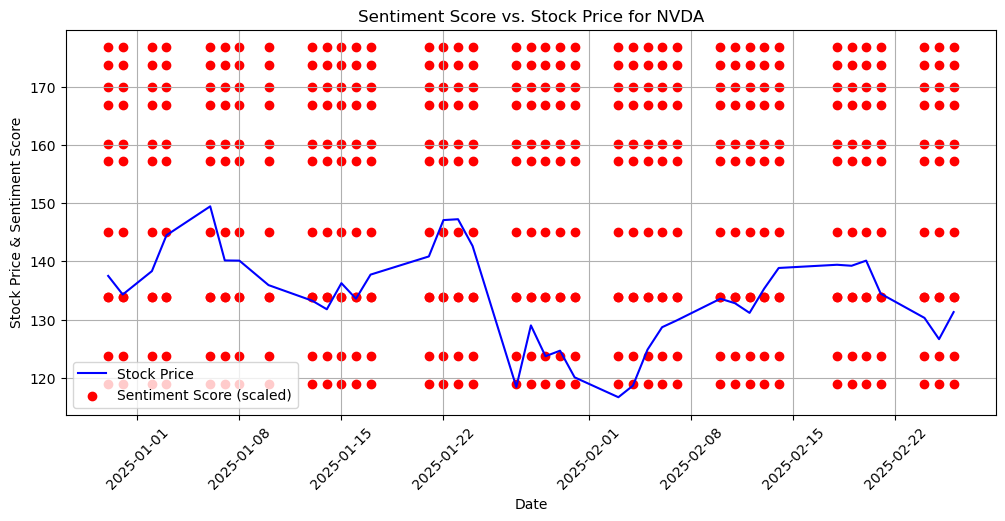

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load cleaned dataset
df = pd.read_csv("final_sentiment_stock_data.csv")

# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort data by Date for better visualization
df = df.sort_values(by=['Date'])

# Select a stock to visualize (e.g., NVDA)
stock_to_visualize = 'NVDA'
stock_df = df[df['Stock Name'] == stock_to_visualize]

# Plot Sentiment Score vs. Close Price
plt.figure(figsize=(12, 5))
plt.plot(stock_df['Date'], stock_df['Close'], label='Stock Price', color='blue')
plt.scatter(stock_df['Date'], stock_df['Sentiment Score'] * 50 + stock_df['Close'].mean(), 
            color='red', label='Sentiment Score (scaled)')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Stock Price & Sentiment Score")
plt.title(f"Sentiment Score vs. Stock Price for {stock_to_visualize}")
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [15]:
import pandas as pd

# Load cleaned dataset
df = pd.read_csv("final_sentiment_stock_data.csv")

# Convert Date column to datetime and sort data
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Stock Name', 'Date'])

# Create Moving Averages for Stock Price
df['MA_7'] = df.groupby('Stock Name')['Close'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df['MA_14'] = df.groupby('Stock Name')['Close'].transform(lambda x: x.rolling(window=14, min_periods=1).mean())
df['MA_30'] = df.groupby('Stock Name')['Close'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

# Compute Price Volatility (Rolling Standard Deviation)
df['Volatility_7'] = df.groupby('Stock Name')['Close'].transform(lambda x: x.rolling(window=7, min_periods=1).std())

# Compute Rolling Sentiment Score Average
df['Sentiment_MA_7'] = df.groupby('Stock Name')['Sentiment Score'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

# Save updated dataset
df.to_csv("feature_engineered_stock_data.csv", index=False)

print(f"✅ Feature-engineered dataset saved with {len(df)} entries.")
print(df.head())


✅ Feature-engineered dataset saved with 624 entries.
          Date                                           Headline  \
544 2024-12-30  Deere shareholders reject anti-DEI proposal, a...   
545 2024-12-30  PayPal has some big new growth targets. Can it...   
542 2024-12-31  Deere shareholders reject anti-DEI proposal, a...   
543 2024-12-31  PayPal has some big new growth targets. Can it...   
540 2025-01-02  Deere shareholders reject anti-DEI proposal, a...   

                                               Summary  Sentiment Score  \
544  Shareholders of Deere & Co. voted overwhelming...          -0.8779   
545  One analyst says the new growth goals seem ach...           0.5106   
542  Shareholders of Deere & Co. voted overwhelming...          -0.8779   
543  One analyst says the new growth goals seem ach...           0.5106   
540  Shareholders of Deere & Co. voted overwhelming...          -0.8779   

    Stock Name       Close        MA_7       MA_14       MA_30  Volatility_7  \
5